Survival Analysis for for Churn
---
Additional padasparallell was tested,

1. data:
   - [src, kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)
   - [src2, Diogo Ribeiro,](https://media.githubusercontent.com/media/DiogoRibeiro7/Medium-Blog/master/survival_analysis/Telco-Customer-Churn.csv)
2. [Article](https://ai.gopubby.com/python-for-advanced-customer-churn-analysis-7b1473b45c3a)
3. [pandas + parallell](https://medium.datadriveninvestor.com/introducing-pandarallel-never-use-the-apply-method-in-pandas-again-5edf898909e7) uses all the cores of CPU!
 ```
  df_group() ➡︎ df_parallel_group()
  df.apply() ➡︎ df_parallel_apply()
  ...
 ```

In [3]:
import pandas as pd
from lifelines import KaplanMeierFitter,CoxPHFitter

import matplotlib.pyplot as plt

In [4]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [23]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [9]:
%time
df['churn']=df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [10]:
%time
df['churn']=df['Churn'].parallel_apply(lambda x: 1 if x=='Yes' else 0)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


```The more the size, the more the efficiency.```

In [27]:
df['Gender']=df['gender'].apply(lambda x: 1 if x=='Female' else 0)

In [28]:
df[['tenure','Gender','churn']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   tenure  7043 non-null   int64
 1   Gender  7043 non-null   int64
 2   churn   7043 non-null   int64
dtypes: int64(3)
memory usage: 165.2 KB


<Axes: xlabel='timeline'>

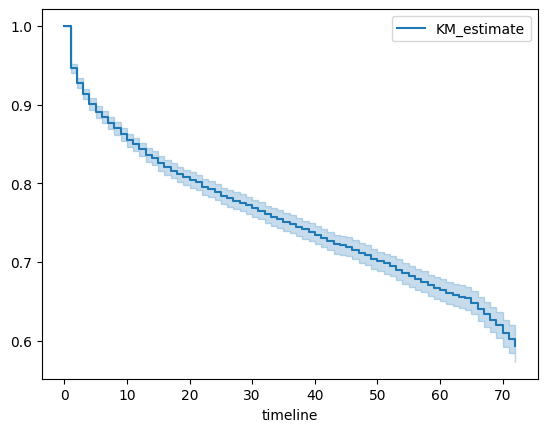

In [30]:
# Initialize the KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the model
# 'duration' is the time to event data
# 'event_observed' is the event indicator (1 if the event occurred, 0 if censored)
kmf.fit(df[['tenure']], event_observed=df['churn'])

# Once the model is fitted, you can plot the survival function
kmf.plot_survival_function()


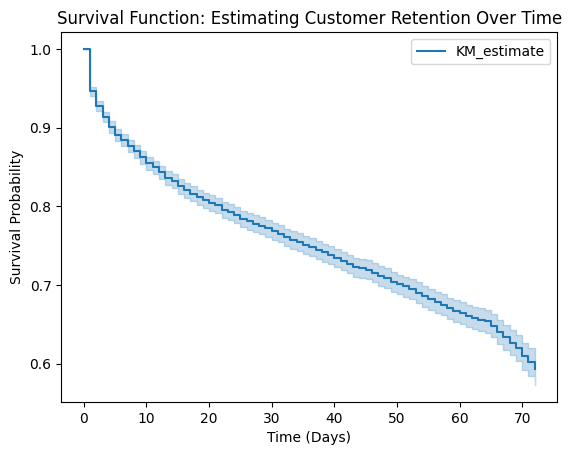

In [14]:
# Plot the survival function
kmf.plot_survival_function()
plt.title('Survival Function: Estimating Customer Retention Over Time')
plt.xlabel('Time (DWeeks)')
plt.ylabel('Survival Probability')
plt.show()

The above plot provides some basic intuition about the customers. The expectation is that, churn is relatively low. From the plot, withing 1-2 years, company retained almost 80-90% of their customers. But there is steady decline and after over 70 months, the company is able to retain almost 60% of their customers. 

In [31]:
# Cox
# https://github.com/saritmaitra/Customer-Churn-analysis/blob/master/Customer%20Churn%20Prediction-Telecom.ipynb

# Initialize the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
# 'duration_col' specifies the column in your DataFrame that contains the duration data
# 'event_col' specifies the column that indicates whether the event (churn) occurred
# The DataFrame passed to 'fit' should also include columns for each covariate you're analyzing
#cph.fit(df[['tenure','churn']], duration_col='tenure', event_col='churn')
cph.fit(df[['tenure','Gender','churn']], 'tenure', event_col='churn')
# Display the model's summary to see the coefficients for each covariate
cph.print_summary()



<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15652.78
         time fit was run = 2024-02-11 15:13:12 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Gender     0.03      1.03      0.05           -0.06            0.12                0.94                1.13

           cmp to    z    p  -log2(p)
covariate                            
Gender       0.00 0.72 0.47      1.09
---
Concordance = 0.51
Partial AIC = 31307.56
log-likelihood ratio test = 0.52 on 1 df
-log2(p) of ll-ratio test = 1.09

<Axes: xlabel='log(HR) (95% CI)'>

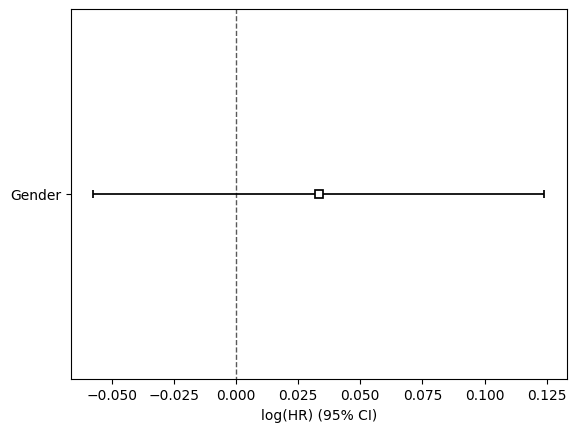

In [32]:
# Optionally, you can visualize the effect of covariates on the hazard
cph.plot()

In [33]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn,Gender
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,No,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,1


In [34]:
dummies = pd.get_dummies(df[[
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod'
]])
df = dummies.join(df[['Gender','MonthlyCharges', 'TotalCharges','churn']])   

In [35]:
df['TotalCharges'] = df[['TotalCharges']].replace([' '], '0')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])


In [36]:
df.head()

,SeniorCitizen,tenure,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender,MonthlyCharges,TotalCharges,churn
0,0,1,False,True,True,False,True,False,False,True,...,False,True,False,False,True,False,1,29.85,29.85,0
1,0,34,True,False,True,False,False,True,True,False,...,True,False,False,False,False,True,0,56.95,1889.50,0
2,0,2,True,False,True,False,False,True,True,False,...,False,True,False,False,False,True,0,53.85,108.15,1
3,0,45,True,False,True,False,True,False,False,True,...,True,False,True,False,False,False,0,42.30,1840.75,0
4,0,2,True,False,True,False,False,True,True,False,...,False,True,False,False,True,False,1,70.70,151.65,1


In [57]:
df_dummies = df.astype(int)
df_dummies.head()

,SeniorCitizen,tenure,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender,MonthlyCharges,TotalCharges,churn
0,0,1,0,1,1,0,1,0,0,1,...,0,1,0,0,1,0,1,29,29,0
1,0,34,1,0,1,0,0,1,1,0,...,1,0,0,0,0,1,0,56,1889,0
2,0,2,1,0,1,0,0,1,1,0,...,0,1,0,0,0,1,0,53,108,1
3,0,45,1,0,1,0,1,0,0,1,...,1,0,1,0,0,0,0,42,1840,0
4,0,2,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,1,70,151,1


In [58]:
from  sklearn.model_selection import train_test_split

In [59]:
from scipy.special import logsumexp

cph_train, cph_test = train_test_split(df_dummies, test_size=0.2)

# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(cph_train, duration_col='tenure', event_col='churn', robust=True)   ## Fit the data to train the model
cph.print_summary(model="telecom churn prediction variables", decimals=3)    ## HAve a look at the significance of the features

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.